### 分组测试额外方法
2022-07-22
- 重新生成数据并保存

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/18316/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

from time import time

import warnings
warnings.filterwarnings("ignore")

se = SpreadEstimator()

In [2]:
univ = se.data.data_dic['volume'] > 0  # 当天有交易
th = 0.8

univ_2 = []
for i in range(2081):
    if np.sum(se.data.data_dic['close'][univ[:,i],i]>10) >= th * 243:
        univ_2.append(1)
    else:
        univ_2.append(0)
univ_2 = np.array(univ_2) > 0
univ_2 = np.repeat(univ_2.reshape(1,2081), 243, 0)

In [3]:
def test_cs(signal, target, univ, back: int = 1):
    corr = []
    for i in range(signal.shape[0]):
        if i < back-1:
            continue
        t = np.nanmean(target[i-back+1: i+1], axis=0)
        se = (~np.isnan(t)) & (~np.isnan(signal[i])) & univ[i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[i, se], t[se])[0, 1])
    print('{:.4f}'.format(np.mean(corr)))
    return corr

def test_ts(signal, target, univ, back: int = 1):
    corr = []
    new_t = np.zeros((len(target)-back+1, target.shape[1]))
    for i in range(new_t.shape[0]):
        new_t[i] = np.nanmean(target[i:i+back])
    for i in range(signal.shape[1]):
        t = new_t[:, i]
        se = (~np.isnan(t)) & (~np.isnan(signal[back-1:, i])) & univ[back-1:, i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[back-1:, i][se], t[se])[0, 1])
    print('{:.4f}'.format(np.mean(corr)))
    return corr

In [4]:
def test_rela(signal, all_univ):
    print('rela cs')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['relative_spread'], u, 20)
    print()

    print('rela ts')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['relative_spread'], u, 20)
    print()

    print('vol_wtd_rel_bas cs ')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['vol_wtd_rel_bas'], u, 20)
    print()

    print('vol_wtd_rel_bas ts ')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['vol_wtd_rel_bas'], u, 20)
        
def test_spread(signal, all_univ):
    print('spread cs')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['spread'], u, 20)
    print()

    print('spread ts')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['spread'], u, 20)

### 以下测试额外方法并保存signal数据

In [38]:
signal_rela = np.zeros((243, 2081, 10), dtype=np.float32)
signal_rela_full = np.zeros((243, 2081, 13), dtype=np.float32)  # 将LOT和Gibbs也加入
signal_spread = np.zeros((243, 2081, 10), dtype=np.float32)

In [54]:
# 收盘价倒数
fml = 'tsmean{close,20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
signal[signal!=0] = 1 / signal[signal!=0]
print()

test_rela(signal, [univ_2])
# print()
# signal[signal!=0] = 1 / signal[signal!=0]
# test_spread(signal, [univ_2])

signal_rela[:, :, -1] = signal

mean corr: -0.3920, positive_corr_ratio: 0.0000, corr_IR: -9.9100

rela cs
0.3260

rela ts
0.3798

vol_wtd_rel_bas cs 
0.3681

vol_wtd_rel_bas ts 
0.3660


0.2332


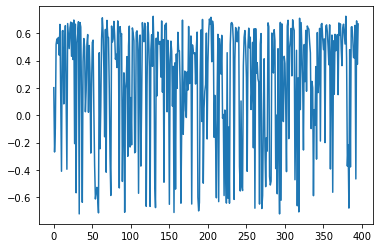

In [59]:
corr = test_ts(signal[:,1400:], se.data.spread_dic['relative_spread'][:, 1400:], univ_2[:, 1400:], 1)
plt.plot(corr)

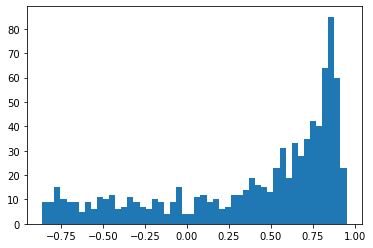

In [57]:
plt.hist(corr, bins=50)
plt.show()

In [41]:
# 收益率绝对值除以对数成交量
fml = 'tsmean{div{absv{tspct{close,1}},logv{volume}},20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()

test_rela(signal, [univ_2])
# print()
# signal[signal!=0] = 1 / signal[signal!=0]
# test_spread(signal, [univ_2])
signal_rela[:, :, 0] = signal

mean corr: -0.3036, positive_corr_ratio: 0.0135, corr_IR: -3.4353

rela cs
0.0273

rela ts
0.1710

vol_wtd_rel_bas cs 
0.0895

vol_wtd_rel_bas ts 
0.2189


In [42]:
# 日振幅
fml = 'tsmean{minus{div{high,low},1},20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()

test_rela(signal, [univ_2])
signal_rela[:, :, 1] = signal

mean corr: -0.2369, positive_corr_ratio: 0.0134, corr_IR: -2.9252

rela cs
0.0039

rela ts
0.0771

vol_wtd_rel_bas cs 
0.0787

vol_wtd_rel_bas ts 
0.1259


In [43]:
# 对数流通市值
fml = 'tsmean{logv{cap},20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()

test_rela(signal, [univ_2])
signal_rela[:, :, 2] = signal

mean corr: -0.4011, positive_corr_ratio: 0.0000, corr_IR: -5.4286

rela cs
-0.5754

rela ts
-0.5267

vol_wtd_rel_bas cs 
-0.5782

vol_wtd_rel_bas ts 
-0.5170


In [34]:
corr = test_cs(signal, se.data.spread_dic['relative_spread'], univ_2, 20)

-0.5754


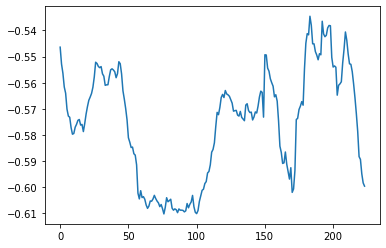

In [35]:
plt.plot(corr)

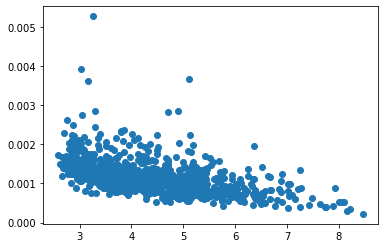

In [25]:
plt.scatter(signal[50, univ_2[50]], se.data.spread_dic['relative_spread'][50, univ_2[50]])

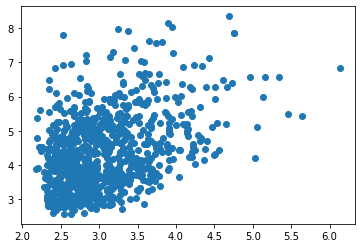

In [29]:
plt.scatter(np.log(se.data.data_dic['close'][50, univ_2[50]]), 
            np.log(se.data.data_dic['cap'][50, univ_2[50]]))

In [30]:
np.corrcoef(np.log(se.data.data_dic['close'][50, univ_2[50]]), 
            np.log(se.data.data_dic['cap'][50, univ_2[50]]))

array([[1.        , 0.41124255],
       [0.41124255, 1.        ]])

In [215]:
# 隔夜收益率
fml = 'tsmean{minus{div{open,tsdelay{close,1}},1},20}'
fml = 'tsmean{absv{div{minus{close,open},minus{high,close}}},20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()

test_rela(signal, [univ_2])
signal_rela[:, :, 3] = signal

mean corr: -0.2177, positive_corr_ratio: 0.0000, corr_IR: -4.5677

rela cs
-0.0957

rela ts
0.1054

vol_wtd_rel_bas cs 
-0.1091

vol_wtd_rel_bas ts 
0.1255


In [206]:
# 波动率
fml = 'tspct{tspct{close,1},20}'
fml = 'tsstd{minus{div{high,low},1},20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()

test_rela(signal, [univ_2])
signal_rela[:, :, 4] = signal

mean corr: -0.0876, positive_corr_ratio: 0.1071, corr_IR: -0.7975

rela cs
0.1112

rela ts
0.0505

vol_wtd_rel_bas cs 
0.1844

vol_wtd_rel_bas ts 
0.0877


In [205]:
# 20日振幅
fml = 'div{tsmax{high,20},tsmin{low,20}}'
fml = 'tsmean{tspct{minus{div{high,low},1},1},19}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()

test_rela(signal, [univ_2])
signal_rela[:, :, 5] = signal

mean corr: 0.0566, positive_corr_ratio: 0.7768, corr_IR: 0.7146

rela cs
0.0820

rela ts
-0.0545

vol_wtd_rel_bas cs 
0.0961

vol_wtd_rel_bas ts 
-0.0544


### 保存经典方法

In [48]:
beta = 'prod{tsmean{powv{minus{logv{high},logv{low}},2},2},2}'

high_1 = 'logv{tsdelay{high,1}}'
low_1 = 'logv{tsdelay{low,1}}'
con_1 = 'condition{gt{logv{low},logv{tsdelay{close,1}}},minus{logv{low},logv{tsdelay{close,1}}},minus{close,close}}'
con_2 = 'condition{lt{logv{high},logv{tsdelay{close,1}}},minus{logv{high},logv{tsdelay{close,1}}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{logv{high},' + con + '}'
low_2 = 'minus{logv{low},' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
signal_rela[:, :, 6] = signal

mean corr: -0.2082, positive_corr_ratio: 0.0000, corr_IR: -3.6871


In [49]:
a = 'tsdelta{logv{close},1}'
b = 'tsdelay{tsdelta{logv{close},1},1}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread')
signal_rela[:, :, 7] = signal

mean corr: 0.0994, positive_corr_ratio: 0.9279, corr_IR: 1.2409


In [50]:
a = 'minus{logv{tsdelay{close,1}},div{add{logv{tsdelay{high,1}},logv{tsdelay{low,1}}},2}}'
b = 'minus{logv{tsdelay{close,1}},div{add{logv{high},logv{low}},2}}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
signal_rela[:, :, 8] = signal

mean corr: -0.2317, positive_corr_ratio: 0.0000, corr_IR: -3.9265


In [216]:
import pickle
with open(r"D:\Documents\学习资料\本科毕业论文\data\signal_rela.pkl", 'wb') as f:
    pickle.dump(signal_rela, f)

### 测试新的算子

In [204]:
fml = 'tsmean{absv{div{minus{close,open},minus{high,close}}},20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()

test_rela(signal, [univ_2])

mean corr: -0.2177, positive_corr_ratio: 0.0000, corr_IR: -4.5677

rela cs
-0.0957

rela ts
0.1054

vol_wtd_rel_bas cs 
-0.1091

vol_wtd_rel_bas ts 
0.1255


In [ ]:
fmls = [
    'tsmean{div{close,open},20}',
    'tsmean{absv{tspct{close,1}},20}',
    'tsmean{logv{volume},20}',
    'tsmean{tspct{minus{div{high,low},1},1},19}',
    'tsstd{minus{div{high,low},1},20}',
    'tsmean{absv{div{minus{close,open},minus{high,close}}},20}'
]

### renew target

In [213]:
target_rela = se.data.spread_dic['relative_spread'].copy()
for i in range(20,243):
    t = np.nanmean(se.data.spread_dic['relative_spread'][i-20:i],axis=0)
    target_rela[i-1] = t

In [214]:
with open(r"D:\Documents\学习资料\本科毕业论文\data\target_rela.pkl", 'wb') as f:
    pickle.dump(target_rela, f)

In [64]:
with open(r"D:\Documents\学习资料\本科毕业论文\data\target_wrela.pkl", 'rb') as f:
    tt = pickle.load(f)

EOFError: Ran out of input

In [219]:
import torch
x = torch.zeros(2, dtype=torch.int)
y = torch.clone(x)

In [220]:
torch.nanmean(x)

RuntimeError: nanmean(): expected input to have floating point dtype but got Int

In [222]:
torch.where(x==0)

(tensor([0, 1]),)